# Aula 04 - Avaliação de Sistemas de Recomendação - Exercícios

In [1]:
import pandas as pd
import numpy as np

### Importar base de dados

In [2]:
# import wget
# !python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
# !tar -xvzf ml-20m-compact.tar.gz

In [3]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

/tmp/ipykernel_56587/3176036202.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('./dataset/ratings_sample.csv')


,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


In [4]:
movies_genres = movies.drop('genres', axis=1).join(movies.genres.str.split('|', expand=True)
             .stack().reset_index(drop=True, level=1).rename('genre'))
movies_genres.head()

,movieId,title,genre
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
1,31,Dangerous Minds (1995),Drama
2,37,Across the Sea of Time (1995),Documentary
2,37,Across the Sea of Time (1995),IMAX


In [5]:
movies_tags = pd.read_csv('./dataset/tags_sample.csv')
movies_tags.head()

,userId,movieId,tag,timestamp_y
0,279,916,Gregory Peck,1329962459
1,279,916,need to own,1329962471
2,279,916,romantic comedy,1329962476
3,279,916,Rome,1329962490
4,279,916,royalty,1329962474


In [6]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)

movies_tags['userId'] = movies_tags['userId'].map(map_users)
movies_tags['movieId'] = movies_tags['movieId'].map(map_items)
movies_tags.dropna(inplace=True)
movies_tags['movieId'] = movies_tags.movieId.astype(int)
movies_tags['userId'] = movies_tags.userId.astype(int)

movies_genres['movieId'] = movies_genres['movieId'].map(map_items)
movies_genres.dropna(inplace=True)
movies_genres['movieId'] = movies_genres.movieId.astype(int)

map_title = {}
for _, row in df.iterrows():
    map_title[row.movieId] = row.title


In [7]:
movies_genres[['movieId', 'genre']].to_csv('items_genres.dat', index=False, sep='\t', header=False)
movies_tags[['movieId', 'tag']].to_csv('items_tags.dat', index=False, sep='\t', header=False)

movies_genres

,movieId,title,genre
0,49,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime
0,49,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
1,61,Dangerous Minds (1995),Drama
2,125,Across the Sea of Time (1995),Documentary
2,125,Across the Sea of Time (1995),IMAX
...,...,...,...
431,394,Berserk: The Golden Age Arc 3 - Descent (2013),Action
431,394,Berserk: The Golden Age Arc 3 - Descent (2013),Animation
431,394,Berserk: The Golden Age Arc 3 - Descent (2013),Fantasy
432,387,Three Quarter Moon (2011),Comedy


### Divisão da base em treino e teste

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.dat', index=False, header=False, sep='\t')
test.to_csv('test.dat', index=False, header=False, sep='\t')

### Exemplos de utilização do CaseRecommender

In [9]:
from caserec.recommenders.rating_prediction.item_attribute_knn import ItemAttributeKNN

ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_genres.dat', k_neighbors=10, as_similar_first=True).compute()
ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_tags.dat', k_neighbors=10, as_similar_first=True).compute()

[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 4.272274 sec
>> metadata:: 417 items and 20 metadata (890 interactions) | sparsity:: 89.33%
prediction_time:: 0.523474 sec
Eval:: MAE: 0.73347 RMSE: 0.964352 
[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 4.036347 sec
>> metadata:: 231 items and 1979 metadata (6274 interactions) | sparsity:: 98.63%
prediction_time:: 0.716261 sec
Eval:: MAE: 0.765116 RMSE: 1.006911 


***Exercício 01:*** Verifique o efeito no RSME ao aumentar o número de vizinhos do algoritmo ItemAttributeKNN com usando gêneros. Explique.

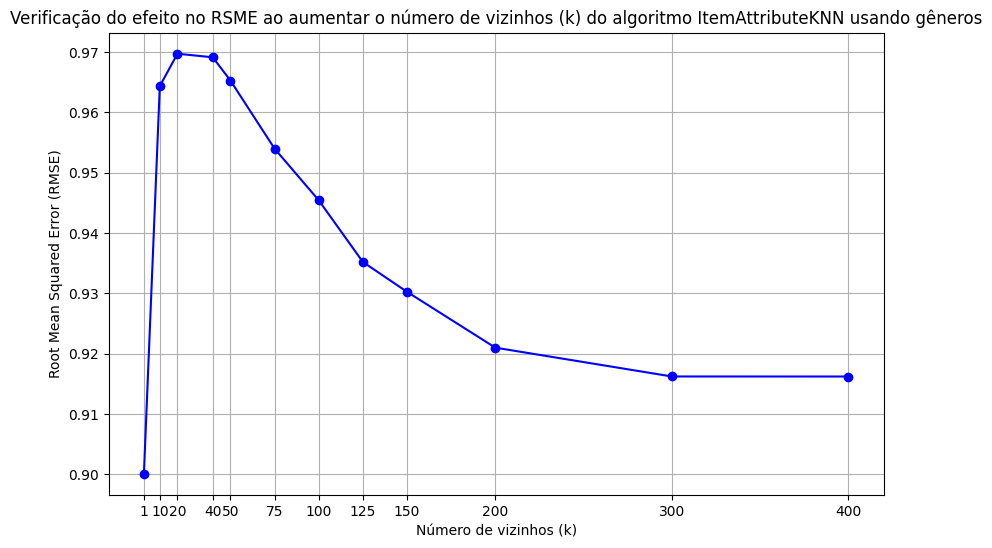

In [10]:
import matplotlib.pyplot as plt
import sys
import io
import re

# Definindo os valores que k vai assumir na análise
k_values = [1, 10, 20, 40, 50, 75, 100, 125, 150, 200, 300, 400]
rmse_results = []

# Aplicar a recomendação para o número estipulado de vizinhos e ver o RSME
for k in k_values:
    recommender = ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_genres.dat',  k_neighbors=k, as_similar_first=True)
    
    # Tendo que pegar o RMSE da saida produzida
    original_stdout = sys.stdout
    captured_output = io.StringIO()
    
    try:
        sys.stdout = captured_output
        recommender.compute()
        
    finally:
        sys.stdout = original_stdout

    output_string = captured_output.getvalue()
    
    match = re.search(r"RMSE: (\d+\.\d+)", output_string)
    
    if match:
        rmse = float(match.group(1))
        rmse_results.append(rmse)
    else:
        rmse_results.append(None)

# Filtrando valores antes da plotagem
valid_k_values = [k for i, k in enumerate(k_values) if rmse_results[i] is not None]
valid_rmse_results = [r for r in rmse_results if r is not None]


# Plotar o resultado com o matplotlib para melhor visuzalização
plt.figure(figsize=(10, 6))
plt.plot(valid_k_values, valid_rmse_results, marker='o', linestyle='-', color='b')

plt.title('Verificação do efeito no RSME ao aumentar o número de vizinhos (k) do algoritmo ItemAttributeKNN usando gêneros')
plt.xlabel('Número de vizinhos (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


***Exercício 02:*** Um importante aspecto que pode ser avaliado em Sistemas de Recomendação é a diversidade da lista de recomendações. A métrica Intra-List Similarity (ILS) aplica uma função de similaridade (e.g. Cosseno, Jaccard, Pearson, etc.) entre todos os pares de itens da lista de recomendação, usando seus metadados como gêneros, tags, etc. Mais detalhes sobre essa métrica podem ser encontrados em: https://grouplens.org/site-content/uploads/Improving-WWW-20051.pdf

***a)*** Implemente uma função que calcula a ILS de uma lista de recomendação para um único usuário. Utilize os gêneros de filmes.

In [20]:
from itertools import combinations
from scipy.spatial.distance import cosine

genres = sorted(movies_genres['genre'].unique())

genreId = {genre: i for i, genre in enumerate(genres)}

def get_genres(movieId):
    if movieId not in movies_genres['movieId'].values:
        return []
    return movies_genres.loc[(movies_genres.movieId==movieId),'genre'].tolist()


def calculate_ils(recommendations):
    # Impossível calcular o ILS de listas com menos de 2 elementos
    if len(recommendations) < 2:
        return 0.0

    num_genres = len(genres)
    item_vectors = []

    # Para cada filme nas recomendações
    for movie_id in recommendations:
        vector = np.zeros(num_genres)
        genres_for_movie = get_genres(movie_id)
        
        for genre in genres_for_movie:
            if genre in genreId:
                vector[genreId[genre]] = 1
        item_vectors.append(vector)

    #Pares, comparar e média
    pairs = list(combinations(item_vectors, 2))
    similarity_scores = [1 - cosine(v1, v2) for v1, v2 in pairs if np.any(v1) and np.any(v2)] #Avaliação de similaridade por cosseno

    return np.mean(similarity_scores) if similarity_scores else 0

***b)*** Utilize a função que implementou no item (a) para calcular a ILS de todos os usuários da base de dados. Utilize as recomendações geradas pelo algoritmo BPR MF do CaseRecommender.

In [12]:
from caserec.recommenders.item_recommendation.bprmf import BprMF

# Treinar o modelo
recommender = BprMF('train.dat', 'test.dat', 'ir_bprmf.dat', factors=3)
recommender.compute()


[Case Recommender: Item Recommendation > BPRMF]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 105.522957 sec
prediction_time:: 3.511712 sec


Eval:: PREC@1: 0.374042 PREC@3: 0.271214 PREC@5: 0.225333 PREC@10: 0.171119 RECALL@1: 0.120825 RECALL@3: 0.251485 RECALL@5: 0.341101 RECALL@10: 0.505743 MAP@1: 0.374042 MAP@3: 0.46667 MAP@5: 0.472804 MAP@10: 0.449566 NDCG@1: 0.374042 NDCG@3: 0.554073 NDCG@5: 0.57581 NDCG@10: 0.577947 


In [22]:
# Aplicar para todos os usuários
test_users = test['userId'].unique()

ils_scores = []

recs = pd.read_csv('./ir_bprmf.dat', sep='\t', names=['userId', 'movieId', 'score'])


# Aplicar para cada usuário
for i, userId in enumerate(test_users):
    # Modelo treinado fornece top 10 recomendações
    
    recs_user = recs.loc[(recs.userId==1), 'movieId'].tolist()
    
    # We can only calculate ILS if we have at least 2 recommendations.
    if len(recs_user) >= 2:
        ils = calculate_ils(recs_user)
        ils_scores.append(ils)

# Carcular o resultado final
if not ils_scores:
    print("\nNão foi possível calcular os ILS")
else:
    average_ils = np.mean(ils_scores)
    print(f"A média dos ILSs para o modelo BprMF: {average_ils:.4f}")
    
    # ProIde a final interpretation
    if average_ils > 0.5:
        print("O modelo produz resultados com baixa diversidade")
    elif average_ils > 0.2:
        print("O modelo produz resultados com diversidade considerável")
    else:
        print("O modelo produz resultados com alta diversidade")

A média dos ILSs para o modelo BprMF: 0.1758
O modelo produz resultados com alta diversidade
